In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
from tqdm.notebook import tqdm
from Utils import plot_graphs
from AkshrantarDataset import AksharantarDataset
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Importing data

### Selecting Language

In [2]:
language = 'tam'
start_token = '<'
end_token = '>'
pad_token = ' '
unk_token = '~'

In [3]:
data = AksharantarDataset(language, start_token, end_token, pad_token, unk_token)
criterion = nn.CrossEntropyLoss(ignore_index=data.tr_l2i[pad_token])

target_dict_count = len(data.tr_l2i)
english_dict_count = len(data.en_l2i)

# Encoder

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers = 1, p = 0, bi_dir = False, rnn_class = nn.GRU):
        """
        Init Parameters:
        input_size : english_dict_count
        embedding_size : size of each embedding vector
        hidden_size : size of hidden state vector
        num_layers : number of recurrent layers of RNN
        p : dropout probability
        rnn_class: type of RNN to be used in the encoder

        Input:
        x : torch.Tensor of shape (seq_length, N)
            where seq_length - len of longest string in the batch
            N - batch size
        
        Outpus:
        outputs: torch.Tensor of shape (seq_len, N, hidden_size * D), where D = 2 if bi_dir = True else 1
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size) if(rnn_class == "LSTM")
        """
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn_class= rnn_class
        self.rnn = rnn_class(embedding_size, hidden_size, num_layers, dropout=p, bidirectional = bi_dir)


    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        if(self.rnn_class.__name__ == "LSTM"):
            outputs, (hidden, cell) = self.rnn(embedding)
            # outputs shape: (seq_length, N, hidden_size)
        else:
            outputs, hidden = self.rnn(embedding)
        
        if(self.rnn_class.__name__ == "LSTM"):
            return outputs, hidden, cell
        else:
            return outputs, hidden


# Decoder

In [5]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers = 1, p = 0, bi_dir = False, rnn_class = nn.GRU):
        """input size = output size = target language charecters
        Init Parameters:
        input_size: target_dict_count
        embedding_size: size of each embedding vector
        hidden_size: size of hidden state vector
        output_size: number of output features in fully connected layer
        num_layers : number of recurrent layers of RNN
        p : dropout probability
        rnn_class: type of RNN to be used in the encoder

        Input:
        x: torch.Tensor of shape (N)
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size)

        Outputs:
        predications: torch.Tensor of shape (N, target_dict_count), where D = 2 if bi_dir = True else 1
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size) if(rnn_class == "LSTM")
        """
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn_class = rnn_class
        self.rnn = rnn_class(embedding_size, hidden_size, num_layers, dropout=p, bidirectional = bi_dir)

        self.D = 1
        if(bi_dir == True):
            self.D = 2
        self.fc = nn.Linear(hidden_size * self.D, output_size)


    def forward(self, x, hidden, cell = None):
        #cell is set to none, for GRU and RNN

        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        # print(x.shape, hidden.shape, cell.shape)
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)
        
        if(self.rnn_class.__name__ == "LSTM"):
            outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
            # outputs shape: (1, N, hidden_size * D)
        else:
            outputs, hidden = self.rnn(embedding, hidden)
            

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        if(self.rnn_class.__name__ == "LSTM"):
            return predictions, hidden, cell
        else:
            return predictions, hidden

# Attention Decoder

In [42]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers = 1, dropout_p=0.1, max_length=50, bi_dir = False, rnn_class = nn.GRU):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size= embedding_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.num_layers = num_layers
        self.D = 1
        if(bi_dir == True):
            D = 2
        self.rnn_class = rnn_class

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.hidden_size + self.embedding_size, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size + self.embedding_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded).unsqueeze(0)
        # print("embed ",embedded.shape)
        # (1, N, es)

        temp = torch.cat((embedded, hidden), 2)
        # print("temp ", temp.shape) # (1, N, hs+es)

        temp = self.attn(temp)
        # print("after attn ", temp.shape) # (1, N, max)

        attn_weights = F.softmax(
            temp, dim=1)
        # print("attn_weights :",attn_weights.shape) # (1, N, max)
        # print("ecn_op: ", encoder_outputs.shape)
        attn_applied = torch.bmm(attn_weights.transpose(0,1),
                                 encoder_outputs.transpose(0,1))
        #attn_applied (N, 1, hs)

        attn_applied = attn_applied.transpose(0,1) #(1, N, hs)
        
        # print("attn appld ", attn_applied.shape) # (1, N, hs)

        output = torch.cat((embedded, attn_applied), 2)
        # print("outpt after cat ",output.shape) # (1, N, hs+es)

        output = self.attn_combine(output)
        # print("after atn comb: ",output.shape) # (1, N, hs)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # print("out ", output.shape, "hid ", hidden.shape)

        prob = self.out(output).squeeze(0) #(1, N, op)
        # print("prob ", prob.shape)

        # output = F.log_softmax(self.out(output[0]), dim=1)
        return prob, hidden, attn_weights

    # def initHidden(self):
    #     return torch.zeros(1, batch_size, self.hidden_size, device=device)    

In [43]:
MAX_LEN = 50
enc = Encoder(input_size= 20, embedding_size=5, hidden_size=10)
o, h = enc(torch.rand(MAX_LEN, 2).int())
print(o.shape, h.shape)
dec = AttnDecoderRNN(embedding_size = 5, hidden_size=10, output_size=40)
p, h, at = dec(torch.zeros(2).int(), h, o)
print(p.shape, h.shape, at.shape)

torch.Size([50, 2, 10]) torch.Size([1, 2, 10])
torch.Size([2, 40]) torch.Size([1, 2, 10]) torch.Size([1, 2, 50])


# Model

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        encoder_layers = encoder.num_layers
        decoder_layers = decoder.num_layers
        D = decoder.D #we set bidiretion as common in both encoder and decoder, so no need to check for D value seperately
        self.enc_to_dec = nn.Linear(encoder_layers*D, decoder_layers*D)
        self.rnn_class = decoder.rnn_class #we use same rnn in both encoder and decoder

    def forward(self, source, target, teacher_forcing = False):
        """source : (source_len, N) - not sure
        teacher_forching_ratio : probability in which original values is favored over predicted values
                                if 0 : predicted values is passed for all chars in target
                                if 1 : true values is passed for all chars in target

        """
        batch_size = source.shape[1] 
        target_len = target.shape[0]
        target_vocab_size = target_dict_count

        # print("source shape ", source.shape)
        # print("target shape ", target.shape)
        # print("N : ", batch_size)
        # print("tar len : ", target_len)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size)
        # print("outputs shape : ", outputs.shape)

        
        if(self.rnn_class.__name__ == "LSTM"):
            enc_ops, hidden, cell = self.encoder(source)
        else:
            enc_ops, hidden = self.encoder(source)

        N = hidden.shape[1]
        hidden_size= hidden.shape[2]
        # hidden, cell shape: (D*encoder_layers, N, hidden_size)

        #UNCOMMENT THIS TO HANDLE dinstinct encoder and decoder layers
        # hidden = hidden.transpose(0, 2) # hidden shape: (hidden_size, N, D*encoder_layers)
        # hidden = hidden.reshape(-1, hidden.shape[2]) # hidden shape: (hidden_size * N, D*encoder_layers)
        # hidden = self.enc_to_dec(hidden) # hidden shape: (hidden_size * N, D*decoder_layers)
        # hidden = hidden.reshape(hidden_size, N, hidden.shape[1]) # hidden shape: (hidden_size, N, D*decoder_layers)
        # hidden = hidden.transpose(0,2) # hidden shape: (D*decoder_layers, N, hidden_size)

        # if(self.rnn_class.__name__ == "LSTM"):
        #     #at all the below steps, cell will have the shape of hidden
        #     cell = cell.transpose(0,2)
        #     cell = cell.reshape(-1, cell.shape[2])
        #     cell = self.enc_to_dec(cell)
        #     cell = cell.reshape(hidden_size, N, cell.shape[1])
        #     cell = cell.transpose(0,2)


        # Grab the first input to the Decoder
        x = target[0]
        outputs[:, :, data.tr_l2i[start_token]] = 1 #setting prob = 1 for starting token 

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            if(self.rnn_class.__name__ == "LSTM"):
                # output, hidden, cell = self.decoder(x, hidden, cell)
                output, hidden, cell, attention = self.decoder(x, hidden, cell, enc_ops)
            else:
                output, hidden, atn = self.decoder(x, hidden, enc_ops)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if teacher_forcing == True else best_guess
        # print("OUTPUTS: ", outputs)
        return outputs


    def calc_accuracy(self, output, target):
        """
        output: torch.Tensor of shape (seq_len, N)
        target: torch.Tensor of shape (seq_len, N)
        """
        # batch_size = 32
        running_acc = 0
        seq_len = output.shape[0]
        N = output.shape[1]
        matched_strings = 0
        with torch.no_grad():
            for j in range(N):
                current_word_matched = True
                for i in range(seq_len):
                    if(target[i][j] == data.tr_l2i[pad_token]): #we dont care whatever prediction in the pad_token place
                        break
                    if(output[i][j] != target[i][j]): #compare the predictions of charecters, start and end_token places
                        current_word_matched = False
                        break
                if(current_word_matched == True):
                    matched_strings += 1
        return matched_strings*100 / N 
    

    def calc_evaluation_metrics(self, src_tar_pair):
        """
        src_tar_pair: a list of tuples, where each tuple consists of two tensors (source, target)
                      source:tensors of shape (seq_len * N), note: seq_len might not be same across all the tensors in the list
                      target:tensors of shape (seq_len * N) 
        """
        num_batches = len(src_tar_pair)
        with torch.no_grad():
            acc = 0
            running_loss = 0
            for source, target in src_tar_pair:
                source = source.to(device)
                target = target.to(device)
                
                output = self(source, target).to(device)
                acc += self.calc_accuracy(output.argmax(2), target)

                output = output.reshape(-1, output.shape[2])
                target = target.reshape(-1)

                loss = criterion(output, target)
                running_loss += loss.item()
        return running_loss/num_batches, acc/num_batches
 

# Training

In [60]:
# Training hyperparameters
num_epochs = 500
learning_rate = 0.01
batch_size = 2

# Model hyperparameters
input_size_encoder = english_dict_count
input_size_decoder = target_dict_count
output_size = target_dict_count
embedding_size = 5
encoder_layers = 1
decoder_layers = 1
enc_dropout = 0.3
dec_dropout = 0.3
hidden_size = 10
bi_directional = False
rnn = nn.GRU

In [61]:
enc = Encoder(english_dict_count, embedding_size, hidden_size, 
              num_layers=encoder_layers, 
              bi_dir=bi_directional,
              p=enc_dropout,
              rnn_class=rnn).to(device)
# dec = Decoder(target_dict_count, embedding_size, hidden_size, target_dict_count, 
#               num_layers=decoder_layers, 
#               bi_dir=bi_directional, 
#               p = dec_dropout,
#               rnn_class=rnn).to(device)

dec = AttnDecoderRNN(embedding_size, hidden_size, output_size=target_dict_count, 
                     num_layers=1,
                     bi_dir = bi_directional,
                     rnn_class= rnn,
                     max_length=MAX_LEN).to(device)

mod = Seq2Seq(enc, dec).to(device)

optimizer = optim.Adam(mod.parameters(), lr=learning_rate)

c:\Users\madhe\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [62]:
train = data.load_data("train", batch_size, num_batches=1, padding_lower_bound=MAX_LEN)
valid = data.load_data("valid", batch_size, num_batches=1, padding_lower_bound=MAX_LEN)

[Epoch   1/500] 	 Loss: 4.070	 Acc: 0.00 	 Val Loss: 3.902	 Val Acc: 0.00
[Epoch   2/500] 	 Loss: 3.869	 Acc: 0.00 	 Val Loss: 3.980	 Val Acc: 0.00
[Epoch   3/500] 	 Loss: 3.726	 Acc: 0.00 	 Val Loss: 3.997	 Val Acc: 0.00
[Epoch   4/500] 	 Loss: 3.657	 Acc: 0.00 	 Val Loss: 3.951	 Val Acc: 0.00
[Epoch   5/500] 	 Loss: 3.584	 Acc: 0.00 	 Val Loss: 3.911	 Val Acc: 0.00
[Epoch   6/500] 	 Loss: 3.492	 Acc: 0.00 	 Val Loss: 3.905	 Val Acc: 0.00
[Epoch   7/500] 	 Loss: 3.399	 Acc: 0.00 	 Val Loss: 3.906	 Val Acc: 0.00
[Epoch   8/500] 	 Loss: 3.350	 Acc: 0.00 	 Val Loss: 3.914	 Val Acc: 0.00
[Epoch   9/500] 	 Loss: 3.283	 Acc: 0.00 	 Val Loss: 3.919	 Val Acc: 0.00
[Epoch  10/500] 	 Loss: 3.195	 Acc: 0.00 	 Val Loss: 3.932	 Val Acc: 0.00
[Epoch  11/500] 	 Loss: 3.128	 Acc: 0.00 	 Val Loss: 3.951	 Val Acc: 0.00
[Epoch  12/500] 	 Loss: 3.054	 Acc: 0.00 	 Val Loss: 3.968	 Val Acc: 0.00
[Epoch  13/500] 	 Loss: 2.989	 Acc: 0.00 	 Val Loss: 3.976	 Val Acc: 0.00
[Epoch  14/500] 	 Loss: 2.937	 Acc: 0.

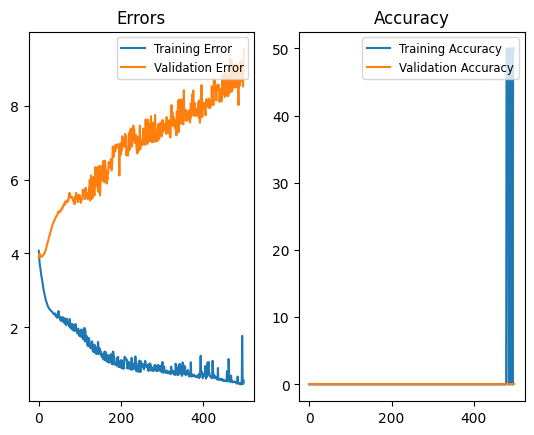

In [63]:
loss_list, acc_list, val_loss_list, val_acc_list = [], [], [], []
teacher_forcing_ratio = 0.5
print_batches = 1

for epoch in range(num_epochs):
    running_loss = 0
    running_accuracy = 0
    total_batches = len(train)

    # for inp_data, target in tqdm(train, desc=f"[Epoch {epoch+1:3d}/{num_epochs}] ", leave = False):        
    for inp_data, target in train:        
        inp_data = inp_data.to(device)
        target = target.to(device)
        
        teacher_forcing = False
        if(epoch < 0.5*num_epochs): #for inital epochs, batch wise tfr
            teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        output = mod(inp_data, target, teacher_forcing).to(device)
        
        if(epoch == num_epochs-1 and print_batches != 0):
            print(data.tensor_to_string(output.argmax(2)))
            print(data.tensor_to_string(target))
            print_batches -= 1

        running_accuracy += mod.calc_accuracy(output.argmax(2), target)

        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mod.parameters(), max_norm=1)
        optimizer.step()
        running_loss += loss.item()

    val_loss, val_accuracy= mod.calc_evaluation_metrics(valid)

    print(f"[Epoch {epoch+1:3d}/{num_epochs}] \t Loss: {(running_loss/total_batches):.3f}\t Acc: {(running_accuracy/total_batches):2.2f} \t Val Loss: {val_loss:2.3f}\t Val Acc: {val_accuracy:2.2f}")
    loss_list.append(running_loss/total_batches)
    acc_list.append(running_accuracy/total_batches)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

fig = plot_graphs(loss_list, val_loss_list, acc_list, val_acc_list)